In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from functools import partial
import pickle
import time
import glob
import copy



from collections import defaultdict
from pathos.multiprocessing import ProcessingPool as Pool
import pathos as pa
from MRP import RandomLayer
from estimates import MC_TD_mult_hor_estimates
from pathlib import Path


plt.rcParams['figure.figsize'] = [10, 5]

## Pooling coefficient / Horizon length

In [2]:
state_a = (0,0)
state_b = (1,0)
HORIZONS = range(10, 121, 10)
np.random.seed(2)
M = RandomLayer(5,HORIZONS[-1], p=0.1)


In [3]:
def get_theorethical_variances(state_a, state_b, horizons, SEED = None):
    """
    Calculate the theoretical MSE for treatment A, treatment B, and the average treatment effect (ATE).

    Parameters:
    - state_a : The state for treatment A.
    - state_b : The state for treatment B.
    - horizons (list): List of horizon lengths.
    - SEED (int, optional): Random seed for reproducibility. Defaults to None.

    Returns:
    - var_diff_TD (list): List of theoretical variances for ATE using TD estimation.
    - var_diff_MC (list): List of theoretical variances for ATE using MC estimation.
    - var_a_TD (list): List of theoretical variances for treatment A using TD estimation.
    - var_b_TD (list): List of theoretical variances for treatment B using TD estimation.
    - var_a_MC (list): List of theoretical variances for treatment A using MC estimation.
    - var_b_MC (list): List of theoretical variances for treatment B using MC estimation.
    """
    ALGS = ['TD', 'MC']
    
    MSE_diffs = {alg: {} for alg in ALGS}
    MSE = {alg: {state: {} for state in [state_a, state_b]} for alg in ALGS}
    Vs = {state: {} for state in [state_a, state_b]} 
    
    
    for D in horizons:
        # Truncate the matrix to horizon D.
        M = RandomLayer(5,D, p = 0, rnd_gen=np.random.default_rng(SEED))        # Compute all the relevant MSEs
        MSE['TD'][state_a][D] = M.asymptotic_TD_variance(state_a)
        MSE['TD'][state_b][D] = M.asymptotic_TD_variance(state_b)
        MSE['MC'][state_a][D] = M.asymptotic_MC_variance(state_a)
        MSE['MC'][state_b][D] = M.asymptotic_MC_variance(state_b)
        
        MSE_diffs['TD'][D] = M.asymptotic_diff_TD_variance(state_a, state_b)
        MSE_diffs['MC'][D] = MSE['MC'][state_a][D] + MSE['MC'][state_b][D]
        Vs[state_a][D] = M.V[state_a]
        Vs[state_b][D] = M.V[state_b]
        
    return MSE, MSE_diffs,Vs


In [4]:
def write_empirical_estimates(horizons, NUM_PATHS_PER_SAMPLE=200, NUM_SAMPLES=1, NUM_PROCESSES=None, write_path=None, SEED=None, overwrite=False):
    """
    Computes empirical estimates of the variance of estimators for different horizons. The estimates are written to write_path.

    Parameters:
    - horizons (list): List of horizon lengths.
    - NUM_PATHS_PER_SAMPLE (int, optional): Number of paths per sample. Defaults to 200.
    - NUM_SAMPLES (int, optional): Number of samples. Defaults to 1.
    - NUM_PROCESSES (int, optional): Number of processes to use for parallel execution. Defaults to None.
    - write_path (str, optional): Path to write the estimates. Defaults to None.
    - SEED (int, optional): Random seed for reproducibility. Defaults to None.
    - overwrite (bool, optional): Whether to overwrite existing estimates. This does not explicitly erase old data. Defaults to False. 
    Returns:
    - None

    """
    def gen_samples(M, timesteps, horizons):
        """
        Generates a sample for a given horizon length.

        Parameters:
        - M (MRP): The MRP to run samples from object.
        - timesteps (list): Ordered list of timesteps. For each timestep k, a screenshot of the value estimates are taken after k samples sample paths have been revealed
        - horizons (list): List of horizon lengths. For each horizon D, a value of the the MRP is truncated to horizon D.

        Returns:
        - estimates (MC_TD_mult_hor_estimates): Summary object containing the estimates for the given timesteps and horizons.

        """
        estimates = MC_TD_mult_hor_estimates(timesteps, horizons, M)
        for _ in range(timesteps[-1]):
            estimates.add_trajectory(M.generate_path())
        return estimates
    
    # If not specified, use maximum number of processes.
    if NUM_PROCESSES is None:
        NUM_PROCESSES = pa.helpers.cpu_count()
        print("Using {} processes.".format(NUM_PROCESSES))
    
    np.random.seed(SEED)
    M = RandomLayer(5,horizons[-1],p = 0, rnd_gen=np.random.default_rng(SEED))
    
    pool = Pool(processes=NUM_PROCESSES)
    # Setting the batch size this way may result in having slightly less than NUM_SAMPLES samples but this is fine.
    BATCH_SIZE = NUM_PROCESSES

    # Copy the MRP structure but change the seed of the random number generator. This is done to ensure that different processes produce independent samples.
    Ms = [copy.deepcopy(M) for _ in range(BATCH_SIZE)]
    for M_ in Ms:
        M_.reseed_gen(np.random.seed(int(1000 * time.time()) % 2**32))
    
    index_start = 0
    if not overwrite:
        for alg in ['MC', 'TD']:
            for hor in horizons:
                path = "{read_path}/horizon_{horizon}_few_cycle/{alg}_starting_batch_".format(read_path=write_path, horizon = hor, alg=alg)
                file_paths = glob.glob(path + "[0-9]*")
                for file_path in file_paths:
                    index_start = max(int(file_path[file_path.rfind("_")+1:])+1, index_start)
                    
    for i in tqdm(range(0, NUM_SAMPLES, BATCH_SIZE)):
        estimates = pool.map(partial(gen_samples, timesteps = [NUM_PATHS_PER_SAMPLE], horizons=horizons), Ms)
        estimates = list(zip(*[zip(data.archive_MC_estimates[0], data.archive_TD_estimates[0]) for data in estimates]))
        if write_path is not None:
            Path(write_path).mkdir(exist_ok=True)
            for (data,hor) in zip(estimates, horizons):
                MC_estimates, TD_estimates = list(zip(*data))
                Path("{write_path}/horizon_{horizon}_few_cycle/".format(write_path = write_path, horizon = hor)).mkdir(exist_ok=True)
                MC_estimates_file = open("{write_path}/horizon_{horizon}_few_cycle/MC_starting_batch_{batch}".format(write_path = write_path, horizon = hor, batch = index_start+i//BATCH_SIZE),"wb")
                TD_estimates_file = open("{write_path}/horizon_{horizon}_few_cycle/TD_starting_batch_{batch}".format(write_path = write_path, horizon = hor, batch = index_start+i//BATCH_SIZE),"wb")
                pickle.dump(MC_estimates,MC_estimates_file)
                pickle.dump(TD_estimates,TD_estimates_file)
                MC_estimates_file.close()
                TD_estimates_file.close()
        

In [7]:
write_empirical_estimates(HORIZONS, NUM_PATHS_PER_SAMPLE=5, NUM_SAMPLES=128, write_path="test", SEED=2, overwrite=True)

Using 8 processes.


100%|██████████| 16/16 [40:01<00:00, 150.11s/it]


In [5]:
def compute_empirical_MSE(state_a, state_b, horizons, read_path, alg_names, Vs, num_path_per_sample):
    """
    Computes the empirical mean squared error (MSE) for different states and horizon lengths.

    Parameters:
    - state_a (tuple): The state for treatment A.
    - state_b (tuple): The state for treatment B.
    - read_path (str): Path to read the estimates.
    - alg_names (list): List of algorithm names.
    - M (MRP): The MRP object.

    Returns:
    - MSE (dict): Dictionary containing the empirical MSE for each algorithm, state, and horizon length.
    - MSE_diffs (dict): Dictionary containing the empirical MSE for the difference between treatment A and treatment B for each algorithm and horizon length.

    """
    MSE = {alg: {state: {} for state in [state_a, state_b]} for alg in alg_names}
    MSE_diffs = {alg: {} for alg in alg_names}
    tot = defaultdict(float)

    for alg_name in alg_names:
        for hor in horizons:
            num_samples = 0
            sum_squared_errors = [0,0,0]
            path = "{read_path}/horizon_{horizon}_few_cycle/{alg}_starting_batch_".format(read_path=read_path, horizon = hor, alg=alg_name)
            # Find all files whose path starts with the prefix
            file_paths = glob.glob(path + "*")

            # Print the file paths
            for file_path in file_paths:
                estimates_file = open(file_path ,"rb")
                estimates = pickle.load(estimates_file)
                estimates_file.close()
                for d in estimates:
                    sum_squared_errors[0] += (d[state_a] - Vs[state_a][hor])**2
                    sum_squared_errors[1] += (d[state_b] - Vs[state_b][hor])**2
                    sum_squared_errors[2] += (d[state_a]-d[state_b] - (Vs[state_a][hor]-Vs[state_b][hor]))**2
                num_samples += len(estimates)
            MSE[alg_name][state_a][hor] = num_path_per_sample*sum_squared_errors[0]/num_samples
            MSE[alg_name][state_b][hor] = num_path_per_sample*sum_squared_errors[1]/num_samples
            MSE_diffs[alg_name][hor] = num_path_per_sample*sum_squared_errors[2]/num_samples
    return MSE, MSE_diffs


In [6]:
MSE_theo, MSE_diffs_theo, Vs = get_theorethical_variances(state_a, state_b, HORIZONS, SEED=2)
MSE_emp, MSE_diffs_emp = compute_empirical_MSE(state_a, state_b, HORIZONS, 'test', ['TD', 'MC'], Vs, 200)


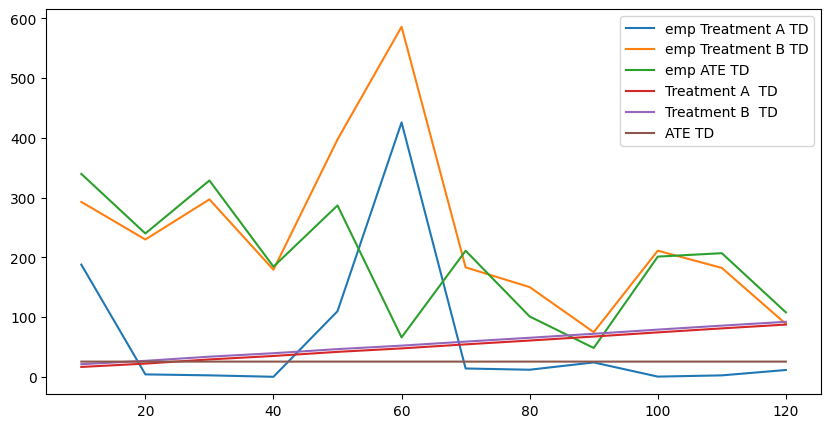

In [7]:
# Uncomment the line corresponding to the algorithm you want to plot.
#ALGS = ['TD', 'MC']
ALGS = ['TD']
#ALGS = ['MC']

for alg in ALGS:
    plt.plot( HORIZONS, MSE_emp[alg][state_a].values(), label="emp Treatment A {}".format(alg))
    plt.plot( HORIZONS, MSE_emp[alg][state_b].values(), label="emp Treatment B {}".format(alg))
    plt.plot( HORIZONS, MSE_diffs_emp[alg].values(), label="emp ATE {}".format(alg))

    plt.plot( HORIZONS, MSE_theo[alg][state_a].values(), label="Treatment A  {}".format(alg))
    plt.plot( HORIZONS, MSE_theo[alg][state_b].values(), label="Treatment B  {}".format(alg))
    plt.plot( HORIZONS, MSE_diffs_theo[alg].values(), label="ATE {}".format(alg))

plt.legend(loc="upper right")